### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, multivariate_normal
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import pandas as pd

%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

In [2]:
def A(x, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(5))
    return np.array([Cbr*(b0 + ba)*r + ib*r - Cab*(ba + a0)*b0 - ia*b0 - (Cm*m + im)*b0 - mb*b0 + ma*ba,
                     Cab*(ba + a0)*b0 + ia*b0 - (Cm*m + im)*ba - ma*ba - mb*ba,
                     Car*(ba + a0)*r + ia*r - (Cm*m + im)*a0 - ma*a0 + mb*ba,
                     (Cm*m + im)*(b0 + a0 + ba) - mm*m,
                     -Cbr*(b0 + ba)*r - ib*r - Car*(ba + a0)*r - ia*r + mb*b0 + ma*a0 + mm*m])

def B(x, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(5))
    return np.array([[Cbr*(b0 + ba)*r + ib*r + Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*b0 + mb*b0 + ma*ba,
                                 -Cab*(ba + a0)*b0 - ia*b0 - ma*ba, 0, -(Cm*m + im)*b0, -Cbr*(b0 + ba)*r - ib*r - mb*b0],
                                [-Cab*(ba + a0)*b0 - ia*b0 - ma*ba, Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*ba + ma*ba + mb*ba,
                                 -mb*ba, -(Cm*m + im)*ba, 0],
                                [0, -mb*ba, Car*(ba + a0)*r + ia*r + (Cm*m + im)*a0 + ma*a0 + mb*ba, -(Cm*m + im)*a0,
                                 -Car*(ba + a0)*r - ia*r - ma*a0],
                                [-(Cm*m + im)*b0, -(Cm*m + im)*ba, -(Cm*m + im)*a0, (Cm*m + im)*(b0 + a0 + ba) + mm*m, -mm*m],
                                [-Cbr*(b0 + ba)*r - ib*r - mb*b0, 0, -Car*(ba + a0)*r - ia*r - ma*a0, -mm*m,
                                 Cbr*(b0 + ba)*r + ib*r + Car*(b0 + a0)*r + ia*r + mb*b0 + ma*a0 + mm*m]
                               ])

def LNA(x, t, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    y = np.maximum(x[:5], np.zeros(5))
    x_det = A(y, *params)
    b0, ba, a0, m, r = y
    Xi = np.reshape(x[5:], (5,5))
    J = np.array([[Cbr*r - Cab*(ba + a0) - ia - (Cm*m + im) - mb, Cbr*r - Cab*b0 + ma, - Cab*b0, - Cm*b0,
                  Cbr*(b0 + ba) + ib], [Cab*(ba + a0) + ia, Cab*b0 - (Cm*m + im) - ma - mb, Cab*b0, - Cm*ba, 0.],
                 [0., Car*r + mb, Car*r - (Cm*m + im) - ma, - Cm*a0, Car*(ba + a0) + ia],
                 [(Cm*m + im), (Cm*m + im), (Cm*m + im), Cm*(b0 + a0 + ba) - mm, 0.],
                 [-Cbr*r + mb, -Cbr*r - Car*r, -Car*r + ma, mm, -Cbr*(b0 + ba) - ib - Car*(ba + a0) - ia]])
    
    dXidt = np.dot(J, Xi) + np.dot(Xi, J.transpose()) + B(y, *params)
    
    return np.concatenate((x_det, dXidt.flatten()))

In [3]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1]
    
    x_t = []
    
    if isinstance(x, float) or isinstance(x, int):
        for  time in t:
            x_t.append(x)
            y = A(x, *params)*dt + np.sqrt(dt*B(x, *params)/N)*np.random.normal()
            x += y
    else:
        n_dim = len(x)
        x_0 = x.copy()
        for time in t:
            x_t.append(x_0.copy())
            y = A(x_0, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(n_dim), B(x_0, *params))
            x_0 += y
            
    return np.array(x_t)

In [4]:
#Cbr = 0.018
#Cab = 0.049
#Cm = 0.078
#Car = 0.021
#mb = 0.003
#ma = 0.013
#mm = 0.017
#ib = 0.0000001
#ia = 0.0000001
#im = 0.0000001
#N = 200

#params = (Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N)

#x0 = [0.1, 0.1, 0.1, 0.1, 0.6]

In [5]:
#dt = 0.1

#t_full = np.arange(0., 365*20., dt)
#x_real = path(x0, t_full, *params)

In [6]:
#fig, ax = plt.subplots(1, figsize=(18,5))
#labels = [r'$b_0$', r'$b_a$', r'$a_0$', r'$m$', r'$r$']
#for i in range(5):
#    ax.plot(t_full/365., x_real[:,i], linewidth=0.75, label=labels[i])
#ax.set_xlabel(r'$t\, \mathrm{(years)}$', fontsize=20)
#ax.legend(fontsize=18)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)

### Code below is not updated...

Need to:
1. Import actual data and pack it into `observations`
2. Define bounds
3. Run estimation
4. Reconstruct process

In [7]:
data = pd.read_csv('interpolated_data.csv', parse_dates=[0], dayfirst=True)

In [8]:
data = data.rename(columns={"'Date'": 'date', "'Barnacles [%]'": 'B', "'Crustose algae [%]'": 'A', "'Mussels [%] '": 'M', "'Bare rock [%]'": 'R'})

In [9]:
b0 = np.empty_like(data.B)
ba = np.empty_like(data.B)
a0 = np.empty_like(data.B)
m = np.empty_like(data.B)
r = np.empty_like(data.B)

for idx, row in data.iterrows():
    if row['B'] + row['M'] + row['R'] > 100.:
        if row['A'] > row['B']:
            b0[idx] = 0.
            ba[idx] = row['B']
            a0[idx] = row['A'] - row['B']
        else:
            b0[idx] = row['B'] - row['A']
            ba[idx] = row['A']
            a0[idx] = 0.
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        if r[idx] < 0:
            m[idx] = m[idx] + r[idx]
            r[idx] = 0.
    elif row['B'] + row['A'] + row['M'] + row['R'] < 100.:
        b0[idx] = row['B']
        ba[idx] = 0.
        a0[idx] = row['A']
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        if r[idx] < 0:
            m[idx] = m[idx] + r[idx]
            r[idx] = 0.
    else:
        ba[idx] = (row['B'] + row['A'] + row['M'] + row['R']) - 100.
        b0[idx] = row['B'] - ba[idx]
        a0[idx] = row['A'] - ba[idx]
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        if r[idx] < 0:
            m[idx] = m[idx] + r[idx]
            r[idx] = 0.
        if b0[idx] < 0:
            ba[idx] = ba[idx] + b0[idx]
            b0[idx] = 0.

In [10]:
data['b0'] = b0/100.
data['ba'] = ba/100.
data['a0'] = a0/100.
data['m'] = m/100.
data['r'] = r/100.

In [11]:
date_init = data.date[0]

data['days'] = data['date'] - date_init
data['days'] = data['days'].apply(lambda x: int(x.days))

In [12]:
data_clean = data.drop(['date', 'B', 'A', 'M', 'R'], axis=1)
data_clean.index = data_clean.days
data_clean = data_clean.drop(['days'], axis=1)

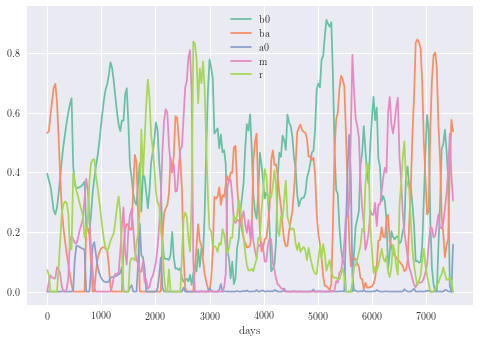

In [13]:
data_clean.plot()

In [25]:
def draw_next(data_now, time_now, time_next, *params):
    n_dim = 1 if (isinstance(data_now, float) or isinstance(data_now, int)) else len(data_now)
    t = np.linspace(time_now, time_next, 10000)
    init_cond = np.array([data_now, 0.]) if n_dim == 1 else np.concatenate((data_now, np.zeros(n_dim**2)))
    lna = odeint(LNA, init_cond, t, args=params)[-1]
    mean = lna[0:n_dim]
    cov = lna[n_dim:]
    N = params[-1]
    if n_dim == 1:
        std = np.sqrt(cov[0]/N)
        return np.random.normal(loc=mean[0], scale=std)
    cov = np.reshape(cov, (n_dim, n_dim))
    return np.random.multivariate_normal(mean, cov/N)
    

def reconstruct(data, times, *params):
    x_t = [data[0]]
    for i in range(len(data)-1):
        x_t.append(draw_next(data[i], times[i], times[i+1], *params[0]))
    return np.array(x_t)

def likelihood_next(data_now, data_next, time_now, time_next, *params):
    n_dim = 1 if (isinstance(data_now, float) or isinstance(data_now, int)) else len(data_now)
    t = np.linspace(time_now, time_next, 10000)
    init_cond = np.array([data_now, 0.]) if n_dim == 1 else np.concatenate((data_now, np.zeros(n_dim**2)))
    lna = odeint(LNA, init_cond, t, args=params)[-1]
    mean = lna[0:n_dim]
    cov = lna[n_dim:]
    N = params[-1]
    if n_dim == 1:
        std = np.sqrt(cov[0]/N)
        dist = norm(loc=mean[0], scale=std)
    else:
        cov = np.reshape(cov, (n_dim, n_dim))
        min_eig = np.min(np.real(np.linalg.eigvals(cov)))
        if min_eig < 0.:
            cov -= 2*min_eig * np.eye(*cov.shape)
        dist = multivariate_normal(mean, cov/N, allow_singular=True)
    return dist.pdf(data_next)
    
def costfn(params, *measurements):
    data, times = measurements
    total = 0.
    for i in range(len(data)-1):
        total -= np.log1p(likelihood_next(data[i], data[i+1], times[i], times[i+1], *params))
    return total

In [21]:
#Cbr = 0.018
#Cab = 0.049
#Cm = 0.078
#Car = 0.021
#mb = 0.003
#ma = 0.013
#mm = 0.017
#ib = 0.0000001
#ia = 0.0000001
#im = 0.0000001
#N = 200

bounds = [(0.0001, 0.5), (0.0001, 0.5), (0.0001, 0.5), (0.0001, 0.5), (0.0001, 0.5), (0.0001, 0.5),
          (0.00001, 0.3), (0.000000001, 0.00001), (0.000000001, 0.00001), (0.000000001, 0.00001), (10, 10000)]

observations = (data_clean.values, data_clean.index.values)

In [22]:
estimation = differential_evolution(costfn, bounds, args=observations)

params_estim = tuple(estimation.x)

In [26]:
x_estim = reconstruct(data_clean.values, data_clean.index.values, params_estim)

/home/cparrar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  del sys.path[0]


In [33]:
Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params_estim

In [36]:
params_table = pd.DataFrame({r'$C_{br}$': Cbr, r'$C_{ab}$': Cab, r'$C_{m}$': Cm, r'$m_{b}$': mb, r'$m_{a}$': ma,
                             r'$m_{m}$': mm, r'$\alpha_{b}$': ib, r'$\alpha_{a}$': ia, r'$\alpha_{m}$': im,
                             r'$N$': N}, index=[0])

params_table

,$C_{ab}$,$C_{br}$,$C_{m}$,$N$,$\alpha_{a}$,$\alpha_{b}$,$\alpha_{m}$,$m_{a}$,$m_{b}$,$m_{m}$
0,0.043566,0.012639,0.015422,22.87661,1.000000e-09,0.000008,1.000000e-09,0.013135,0.0001,0.005071


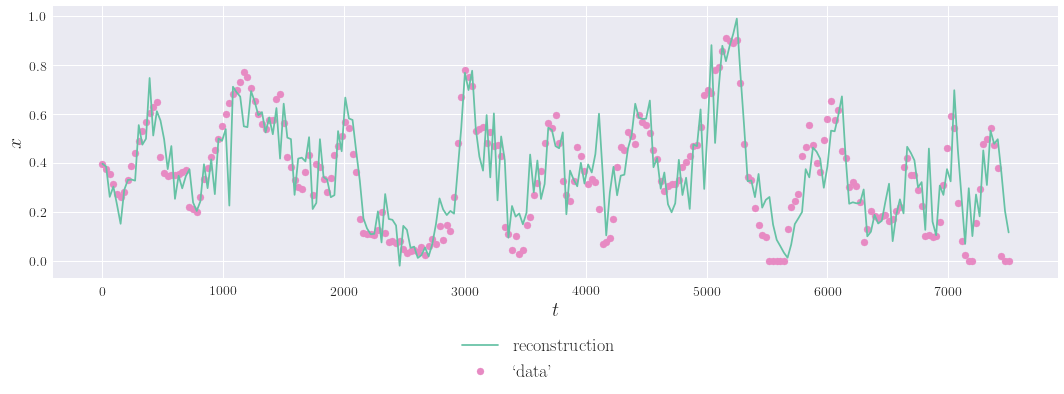

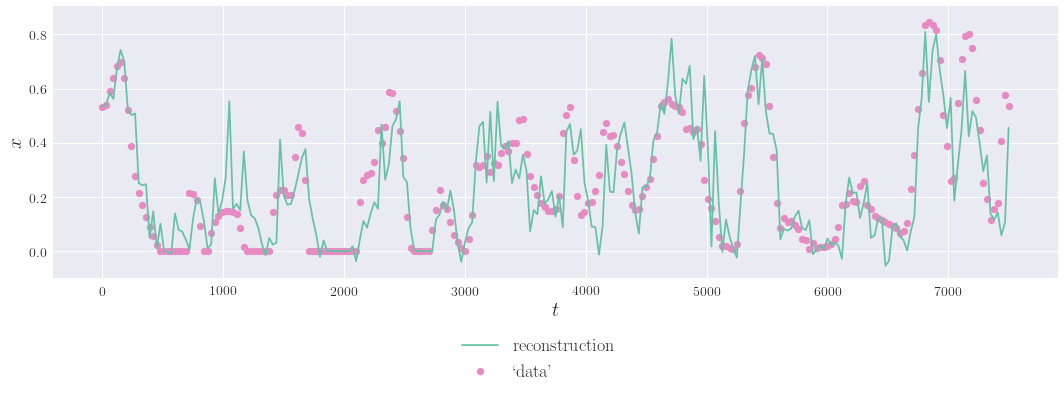

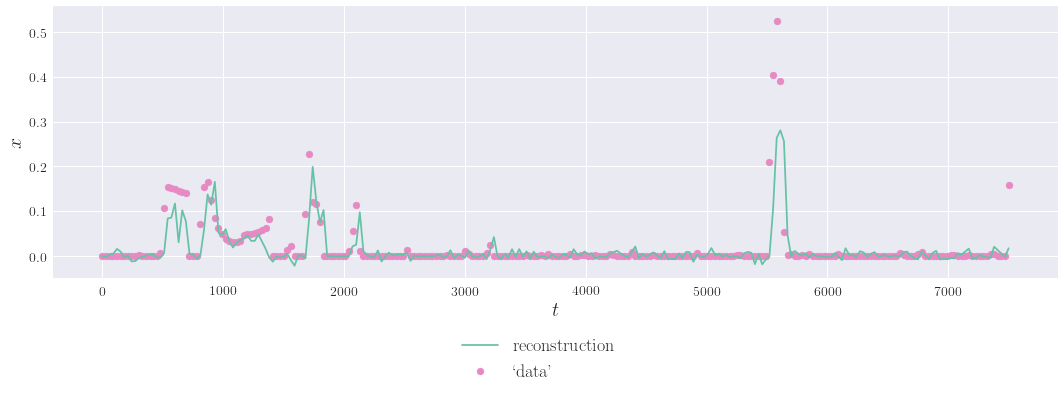

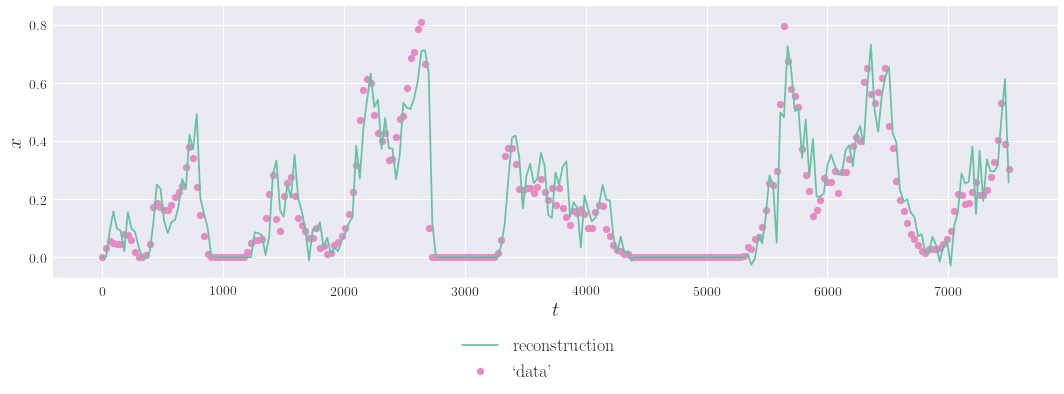

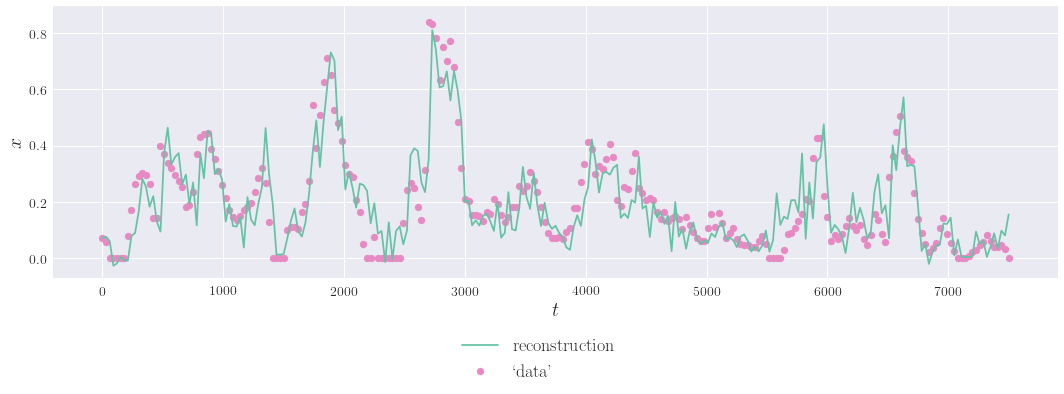

In [32]:
for i in range(5):
    fig, ax = plt.subplots(1, figsize=(18,5))
    ax.plot(data_clean.index.values, x_estim[:,i], label=r'reconstruction')
#if n_dims == 1:
#    ax.scatter(artificial_timepoints, artificial_data, label=r"`data'", color=colours[1])
#else:
    ax.scatter(data_clean.index.values, data_clean.values[:, i], color=colours[3], label=r"`data'")
#    ax.scatter(artificial_timepoints, artificial_data[:, 1], color=colours[2], label=r"`data'")
    ax.set_xlabel(r'$t$', fontsize=20)
    ax.set_ylabel(r'$x$', fontsize=20)
    ax.legend(fontsize=18, loc=(0.4,-0.4))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [ ]:
init_cond = np.array([x0, 0.]) if n_dims == 1 else np.concatenate((x0, np.zeros(4)))
x_real_det = odeint(LNA, init_cond, t_full, args=params)[:, :n_dims]
x_estim_det = odeint(LNA, init_cond, t_full, args=params_estim)[:, :n_dims]

In [ ]:
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(t_full, x_real_det, linewidth=0.75, label=r"deterministic underlying process")
ax.plot(t_full, x_estim_det, linewidth=0.75, label=r"deterministic estimated process")
ax.set_xlabel(r'$t$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
if n_dims == 1:
    params_table = {'process': ['real', 'estimated'], r'$b$': [b, params_estim[0]], r'$d$': [d, params_estim[1]], r'$N$': [N, params_estim[2]]}
else:
    params_table = {'process': ['real', 'estimated'], r'$\beta$': [beta, params_estim[0]], r'$\gamma$': [gamma, params_estim[1]], r'$N$': [N, params_estim[2]]}
params_table = pd.DataFrame(params_table)
params_table.set_index(['process'])